# Feature distributions

* Which features should be translated to log
* How features correlate
* PCA of features

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Imports and database setup

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.features import SubstitutionFeaturesMixin

First build our data

In [15]:
words = set()
for feature in SubstitutionFeaturesMixin.__features__:
    words.update(getattr(SubstitutionFeaturesMixin, '_' + feature)())

words = sorted(words)
data = dict((feature, np.zeros(len(words)))
            for feature in SubstitutionFeaturesMixin.__features__)
for i, word in enumerate(words):
    for feature in SubstitutionFeaturesMixin.__features__:
        data[feature][i] = getattr(SubstitutionFeaturesMixin, '_' + feature)(word)

data['word'] = words
features = pd.DataFrame(data)
del data, words

## 2 Which features should be translated to log

We compute the distribution of feature values, for each feature. When a distribution is very skewed, it's a good idea to translate it to log.

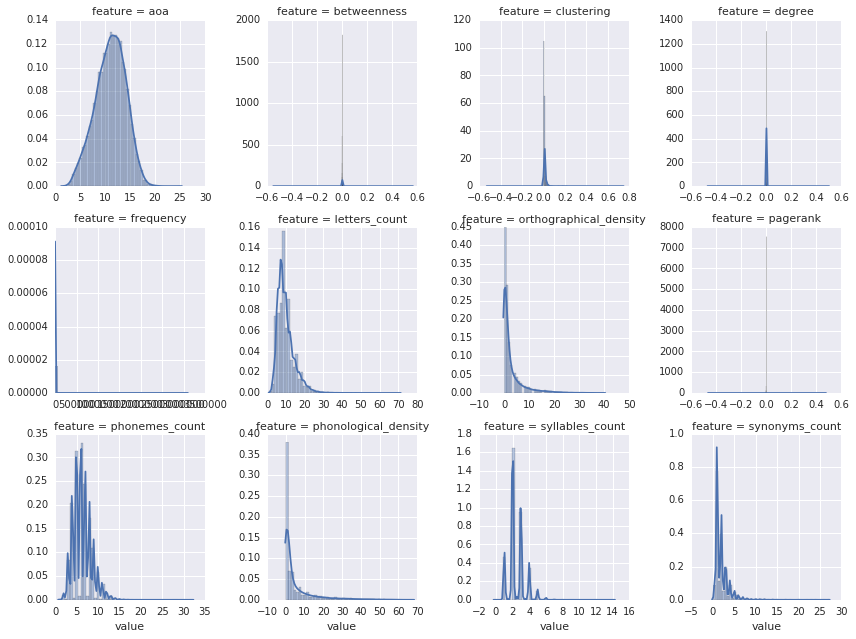

In [18]:
g = sb.FacetGrid(pd.melt(features, id_vars='word', var_name='feature'),
                 col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sb.distplot, 'value')

Conclusion: **all features except `aoa`, `letters_count`, `phonemes_count`, and `syllables_count` should be translated to log** so we can see better.

## 3 Feature correlations

## 4 PCA on features